# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. 


## Подготовка данных

In [292]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [293]:
import pandas as pd
import numpy as np
import phik 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [294]:
data=pd.read_csv('/datasets/Churn.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [295]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [296]:
data['Exited'].value_counts() 

0    7963
1    2037
Name: Exited, dtype: int64

In [297]:
data.isna().sum() 

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [298]:
data.phik_matrix() 

interval columns not set, guessing: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Surname is large: 2932. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.
  warnings.warn(


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.000000,0.000000,0.041080,0.030864,0.000000,0.033746,0.000000,0.000000,0.014601,0.010813,0.000000,0.000000,0.000000
CustomerId,0.000000,1.000000,0.000000,0.018946,0.000000,0.000000,0.042049,0.009340,0.000000,0.009637,0.000000,0.014253,0.000000,0.029595
Surname,0.000000,0.000000,1.000000,0.242957,0.001476,0.040711,0.333753,0.020624,0.483668,0.201225,0.000000,0.000000,0.083242,0.000000
CreditScore,0.041080,0.018946,0.242957,1.000000,0.035375,0.000000,0.000000,0.000000,0.000000,0.034645,0.000000,0.038064,0.034215,0.096525
Geography,0.030864,0.000000,0.001476,0.035375,1.000000,0.013354,0.085025,0.003879,0.463811,0.049418,0.002919,0.010947,0.028372,0.104511
Gender,0.000000,0.000000,0.040711,0.000000,0.013354,1.000000,0.033815,0.031054,0.000000,0.063174,0.000000,0.031384,0.028019,0.165422
Age,0.033746,0.042049,0.333753,0.000000,0.085025,0.033815,1.000000,0.046402,0.035357,0.145566,0.016433,0.187434,0.051545,0.487524
Tenure,0.000000,0.009340,0.020624,0.000000,0.003879,0.031054,0.046402,1.000000,0.063973,0.060387,0.031409,0.027321,0.000000,0.020845
Balance,0.000000,0.000000,0.483668,0.000000,0.463811,0.000000,0.035357,0.063973,1.000000,0.371385,0.050671,0.018236,0.000000,0.183365
NumOfProducts,0.014601,0.009637,0.201225,0.034645,0.049418,0.063174,0.145566,0.060387,0.371385,1.000000,0.000000,0.056918,0.031562,0.565084


In [299]:
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [300]:
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


In [301]:
not_informative = ['RowNumber', 'CustomerId', 'Surname', 'Tenure', 'HasCrCard', 'EstimatedSalary']
data = data.drop(columns=not_informative)

In [302]:
categorical = ['Geography', 'Gender', 'IsActiveMember']
data=pd.get_dummies(data, columns=categorical, drop_first=True) 
print(data.head(3))

   CreditScore  Age    Balance  NumOfProducts  Exited  Geography_Germany  \
0          619   42       0.00              1       1                  0   
1          608   41   83807.86              1       0                  0   
2          502   42  159660.80              3       1                  0   

   Geography_Spain  Gender_Male  IsActiveMember_1  
0                0            0                 1  
1                1            0                 1  
2                0            0                 0  


In [303]:
data_train, data_valid=train_test_split(data, test_size=0.4, random_state=12345, stratify=data['Exited']) 
data_valid, data_test=train_test_split(data_valid, test_size=0.5, random_state=12345, stratify=data_valid['Exited'])
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(6000, 9)
(2000, 9)
(2000, 9)


In [304]:
features_train = data_train.drop(['Exited'], axis=1) 
target_train = data_train['Exited']
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']
features_test=data_test.drop(['Exited'], axis=1)
target_test=data_test['Exited']
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 8)
(6000,)
(2000, 8)
(2000,)
(2000, 8)
(2000,)


In [305]:
numeric = ['Age', 'Balance', 'NumOfProducts', 'CreditScore']  

In [306]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

    Для начала загрузим датасет с данными по клиентам и изучим эти данные. В данныых есть признаки, которые не нужны нам для обучения модели (индекс строки, id клиента и фамилия), эти столбцы я удалю, так как по этим данным никак нельзя спрогнозировать уйдёт клиент или нет. Также в таблице есть пропуски в столбце Tenure, этот признак я оставляю, потому что важно, сколько лет человек являлся клиентом банка, заполню пропуски нулём, так как предположу, что это новые клиенты, которые явдяются клиентами банка меньше года. Далее я закодировала категориальные признаки, отдельно вынесла числовые признаки и масштабировала их. Разбила наш датасет на 3 выборки: обучающую, валидационную и тестовую, в соотношении (60/20/20).Проверила, всё корректно. Также проверим наш таргет на дисбаланс: ушло-2037, осталось-7963 клиента. Получается ушло из банка практически 1/5.

## Исследование задачи

In [307]:
%%time
model_l = LogisticRegression(random_state=12345, solver='liblinear')
model_l.fit(features_train, target_train)
predicted_valid = model_l.predict(features_valid)
probabilities_valid = model_l.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("auc_roc_l:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

auc_roc_l: 0.7872096388806779
F1: 0.3107861060329068
CPU times: user 8.02 ms, sys: 92.1 ms, total: 100 ms
Wall time: 42.7 ms


In [308]:
%%time

C_ = [0.2, 0.5, 1.0, 2.0]
max_iter_ = [100, 300, 500]

best_model_l=None 
best_result=0
#for c in range(1,20):
#    for max_it in range(1,20):
for c in range(1,20):
    for max_it in range(1,20):
        model_l=LogisticRegression(random_state=12345, C=c, max_iter=max_it)
        model_l.fit(features_train, target_train)
        predictions_valid=model_l.predict(features_valid)
        result=f1_score(target_valid, predictions_valid)
        if result>best_result:
            best_model_t=model_l
            best_result=result
display(best_result, best_model_l)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.3194192377495463

None

CPU times: user 17.5 s, sys: 46.6 s, total: 1min 4s
Wall time: 1min 4s


In [309]:
model_t = DecisionTreeClassifier(random_state=12345) #обучим дерево
model_t.fit(features_train, target_train)
predicted_valid = model_t.predict(features_valid)
probabilities_valid = model_t.predict_proba(features_valid)
probabilities_two_valid = probabilities_valid[:, 1]
print("auc_roc_t:", roc_auc_score(target_valid, probabilities_two_valid))
print("F1:", f1_score(target_valid, predicted_valid))

auc_roc_t: 0.7177923933392453
F1: 0.5463182897862233


In [310]:
best_model_t=None 
best_result=0
for depth in range(1,20):
    for min_sample in range(1,20):
        model_t=DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=min_sample)
        model_t.fit(features_train, target_train)
        predictions_valid=model_t.predict(features_valid)
        result=f1_score(target_valid, predictions_valid)
        if result>best_result:
            best_model_t=model_t
            best_result=result
display(best_result, best_model_t)

0.608089260808926

DecisionTreeClassifier(max_depth=13, min_samples_leaf=12, random_state=12345)

In [311]:
model_f = RandomForestClassifier(random_state=12345)
model_f.fit(features_train, target_train)
predicted_valid = model_f.predict(features_valid)
probabilities_valid = model_f.predict_proba(features_valid)
probabilities_three_valid = probabilities_valid[:, 1]
print("auc_roc_f:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

auc_roc_f: 0.7872096388806779
F1: 0.5968882602545968


In [312]:
%%time
best_model_f = None 
best_result = 0
for est in range(50, 300, 10):
    for depth in range(1,15,3):
        model_f= RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_f.fit(features_train, target_train)
        predicted_valid=model_f.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model_f=model_f
            best_result = result
display(best_result, best_model_f)

0.6102189781021896

RandomForestClassifier(max_depth=13, n_estimators=150, random_state=12345)

CPU times: user 1min 13s, sys: 684 ms, total: 1min 14s
Wall time: 1min 14s


    Обучила три модели:случайный лес, решающее дерево и логистическая регрессия, лучший результат f1 получила при случайном дереве, также посмотрела, как меняется метрика при изменении глубины дерева. Лучшее значение при глубине 16, f1= 0,609.

## Борьба с дисбалансом

In [313]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model_f_best=RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=190)
model_f_best.fit(features_upsampled, target_upsampled)
predicted_valid=model_f_best.predict(features_valid)
probabilities_valid = model_f_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_model_f1 = None 
best_result1 = 0
for est in range(50, 300, 10):
    for depth in range(1,15,3):
        model_f_best= RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_f_best.fit(features_upsampled, target_upsampled)
        predicted_valid=model_f_best.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result1:
            best_model_f1=model_f_best
            best_result1 = result
display(best_result1, best_model_f1)

print("F1_f:", f1_score(target_valid, predicted_valid))

model_l_best= LogisticRegression(random_state=12345, solver='liblinear')
model_l_best.fit(features_upsampled, target_upsampled)
predicted_valid = model_l_best.predict(features_valid)
print("F1_l:", f1_score(target_valid, predicted_valid))
probabilities_valid = model_l_best.predict_proba(features_valid)
probabilities_two_valid = probabilities_valid[:, 1]

model_t_best = DecisionTreeClassifier(max_depth=7, random_state=12345) 
model_t_best.fit(features_upsampled, target_upsampled)
predicted_valid = model_t_best.predict(features_valid)
print("F1_t:", f1_score(target_valid, predicted_valid))
probabilities_valid = model_t_best.predict_proba(features_valid)
probabilities_three_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid =probabilities_one_valid>threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall =recall_score(target_valid, predicted_valid)
    f1=f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

0.6499999999999999

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=12345)

F1_f: 0.6278240190249703
F1_l: 0.5258620689655172
F1_t: 0.5834109972041006
Порог = 0.00 | Точность = 0.204, Полнота = 1.000
Порог = 0.02 | Точность = 0.204, Полнота = 1.000
Порог = 0.04 | Точность = 0.208, Полнота = 1.000
Порог = 0.06 | Точность = 0.219, Полнота = 0.993
Порог = 0.08 | Точность = 0.231, Полнота = 0.990
Порог = 0.10 | Точность = 0.240, Полнота = 0.988
Порог = 0.12 | Точность = 0.253, Полнота = 0.980
Порог = 0.14 | Точность = 0.264, Полнота = 0.966
Порог = 0.16 | Точность = 0.277, Полнота = 0.958
Порог = 0.18 | Точность = 0.290, Полнота = 0.949
Порог = 0.20 | Точность = 0.303, Полнота = 0.936
Порог = 0.22 | Точность = 0.321, Полнота = 0.924
Порог = 0.24 | Точность = 0.339, Полнота = 0.919
Порог = 0.26 | Точность = 0.357, Полнота = 0.912
Порог = 0.28 | Точность = 0.376, Полнота = 0.904


In [314]:
auc_roc_f=roc_auc_score(target_valid, probabilities_one_valid) 
auc_roc_f

0.8740285372943147

In [315]:
auc_roc_l=roc_auc_score(target_valid, probabilities_two_valid) 

0.7937558503300818

In [316]:
auc_roc_t=roc_auc_score(target_valid, probabilities_three_valid) #
auc_roc_t

0.8357096450389202

Text(0.5, 1.0, 'ROC-кривая')

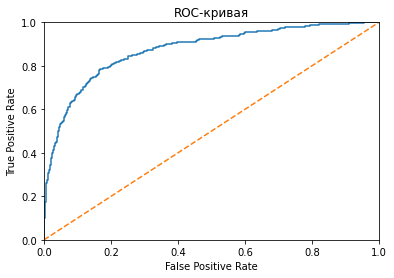

In [317]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

In [318]:
def downsample(features, target, fraction): 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)


model_f_best2=RandomForestClassifier(max_depth=12, n_estimators=310, random_state=29)
model_f_best2.fit(features_downsampled, target_downsampled)
predicted_valid=model_f_best2.predict(features_valid)
probabilities_valid = model_f_best2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1_f:", f1_score(target_valid, predicted_valid))

model_l_best2= LogisticRegression(random_state=12345, solver='liblinear')
model_l_best2.fit(features_downsampled, target_downsampled)
predicted_valid = model_l_best2.predict(features_valid)
print("F1_l:", f1_score(target_valid, predicted_valid))
probabilities_valid = model_l_best2.predict_proba(features_valid)
probabilities_two_valid = probabilities_valid[:, 1]

model_t_best2 = DecisionTreeClassifier(max_depth=7, random_state=12345) 
model_t_best2.fit(features_downsampled, target_downsampled)
predicted_valid = model_t_best2.predict(features_valid)
print("F1_t:", f1_score(target_valid, predicted_valid))
probabilities_valid = model_t_best2.predict_proba(features_valid)
probabilities_three_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid =probabilities_one_valid>threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall =recall_score(target_valid, predicted_valid)
    f1=f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

F1_f: 0.4904163912756113
F1_l: 0.4235423542354236
F1_t: 0.4691525423728813
Порог = 0.00 | Точность = 0.204, Полнота = 1.000
Порог = 0.02 | Точность = 0.204, Полнота = 1.000
Порог = 0.04 | Точность = 0.205, Полнота = 1.000
Порог = 0.06 | Точность = 0.207, Полнота = 1.000
Порог = 0.08 | Точность = 0.209, Полнота = 0.998
Порог = 0.10 | Точность = 0.212, Полнота = 0.995
Порог = 0.12 | Точность = 0.215, Полнота = 0.995
Порог = 0.14 | Точность = 0.219, Полнота = 0.995
Порог = 0.16 | Точность = 0.223, Полнота = 0.995
Порог = 0.18 | Точность = 0.227, Полнота = 0.993
Порог = 0.20 | Точность = 0.230, Полнота = 0.990
Порог = 0.22 | Точность = 0.234, Полнота = 0.990
Порог = 0.24 | Точность = 0.238, Полнота = 0.990
Порог = 0.26 | Точность = 0.241, Полнота = 0.985
Порог = 0.28 | Точность = 0.245, Полнота = 0.980


In [319]:
auc_roc_f=roc_auc_score(target_valid, probabilities_one_valid)
auc_roc_f

0.8545346216375997

In [320]:
auc_roc_l=roc_auc_score(target_valid, probabilities_two_valid)
auc_roc_l

0.7989965144349197

In [321]:
auc_roc_t=roc_auc_score(target_valid, probabilities_three_valid)
auc_roc_t

0.7883512230268992

    Увеличила и уменьшила обучающие выборки, при уменьшении выборки, показатель f1 падает, при увеличении значение F1 остаётся неизменным. AUC_ROC= 0,86

## Тестирование модели

In [322]:
features_train_plus=pd.concat([features_train, features_valid])
target_train_plus=pd.concat([target_train, target_valid])

In [323]:
model_f_plus=RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=200)
model_f_plus.fit(features_upsampled, target_upsampled)
predicted_valid_plus=model_f_plus.predict(features_train_plus)
probabilities_valid_plus = model_f_plus.predict_proba(features_train_plus)
probabilities_one_valid_plus = probabilities_valid_plus[:, 1]

In [324]:
predictions_test=model_f_plus.predict(features_test)
probabilities_test = model_f_plus.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print("Тестовая выборка F1:", f1_score(target_test, predictions_test))
print('Тестовая выборка AUC_ROC:', roc_auc_score(target_test, probabilities_one_test))

Тестовая выборка F1: 0.5923497267759563
Тестовая выборка AUC_ROC: 0.851594275323089


<div class="alert alert-warning"> <b>ВЫВОД:</b> "Бэта-банк" банк нам предоставил исторические данные по поведении клиентов, некоторые из которых ушли из банка. Стояла задача постороить модель, которая максимально точно спрогнозирует уйдёт ли клиент из банка или нет. В ходе изучения данных стало понятно, что некоторая информация неинформативна, такая как: Фамилия клиента, индес строки и Id клиента, решила их удалить, чтобы не перезагружать модель. Также присутствовал один столбец с пропусками (скольео лет человек является клиентом банка), я проверила как он коррелирует с целевым признаком и тоже решила удалить, так как корреляция слабо отрицательная. Затем я определила категориальные данные и обработала их методом OHE, так же масштабировала численные данные. Разделила наш датасет на три выборки: обучающую, валидационную и тестовую. Далее я создала три модели обучения, и путем подбора гиперпараметров определилась с лучшей моделью. Лучшие F1 0.619 результаты получились в модели случайного леса. Также поскольку наблюдался дисбаланс в таргете для увеличения качества модели проверила увеличение и уменьшение выборки. При увеличении выборки также лучший результат дал случайный лес F1 0.624 и AUC_ROC, при этом я изменила гиперпараметры max_depth=23, n_estimators=29 для улучшения модели. При тестировании модели результаты упали до F1 0.58 и AUC_ROC 0.83